# WNTR Earthquake Demo
This demonstration covers how to run simple earthquake analysis with partial repairs using WNTR.

### 1 Simulation set up

#### 1a Import packages
Numpy, Pandas, Matplotlib, and SciPy are required to support data handling and graphics/plotting.

In [1]:
import wntr
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.stats import expon

np.random.seed(12345)

# Set colormap for network maps
cmap=plt.cm.get_cmap('viridis')

#### 1b Create a water network model and define earthquake characteristics
If adapting code for a different INP file, the following code needs to be changed to reflect the correct file path and desired simulation parameters.

In [2]:
# Identify file path to inp file
inp_file = "../networks/Net3.inp"

# Create water network model 
wn = wntr.network.WaterNetworkModel(inp_file)

# Morph network coordinates, this is optional
wn = wntr.morph.scale_node_coordinates(wn, 1000) 

# Define simulation parameters 
epicenter = (32000,15000) # m (x,y)
magnitude = 6.5 # Richter magnitude
depth = 10000 # m

total_duration = 24*3600 # 24 hours

minimum_pressure = 3.52 # 5 psi
required_pressure = 14.06 # 20 psi

leak_start_time = 5*3600 # 5 hours
leak_repair_time =  15*3600 # 15 hours

#### 1c Visualize epicenter on water network model

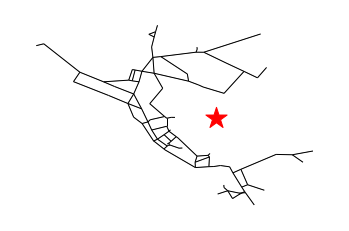

In [3]:
wntr.graphics.plot_network(wn, node_size=0)
plt.scatter(epicenter[0], epicenter[1], s=500, c='r', marker='*', zorder=2)

### 2 Create earthquake object 

#### 2a Initiate earthquake object and define peak ground acceleration (PGA), peak ground velocity (PGV), and repair rates (RR)
The parameters defined in **1b** are used to generate fragility curves. Fragility curves are used to define the probability of damage with respect to PGA, PGV, and/or RR.

In [4]:
# Initializes earthquake object
earthquake = wntr.scenario.Earthquake(epicenter, magnitude, depth) 

# Calculates PGA, PGV, and RR
R = earthquake.distance_to_epicenter(wn, element_type=wntr.network.Pipe)
pga = earthquake.pga_attenuation_model(R)  
pgv = earthquake.pgv_attenuation_model(R)
RR = earthquake.repair_rate_model(pgv)

# Queries pipe lengths for all pipes in the network
L = pd.Series(wn.query_link_attribute('length', link_type = wntr.network.Pipe))

# Generates fragility curve
pipe_FC = wntr.scenario.FragilityCurve()
pipe_FC.add_state('Minor Leak', 1, {'Default': expon(scale=0.2)})
pipe_FC.add_state('Major Leak', 2, {'Default': expon()})

#### 2b Plot fragility curve

<AxesSubplot:title={'center':'Fragility Curve'}, xlabel='Rate of repair * pipe length', ylabel='Probability of exceeding a damage state'>

<Figure size 432x288 with 0 Axes>

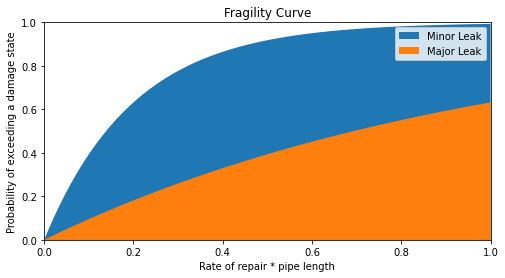

In [5]:
plt.figure()
wntr.graphics.plot_fragility_curve(pipe_FC, title = 'Fragility Curve', xlabel='Rate of repair * pipe length')

#### 2c Calculate and check leak probabilities

In [6]:
# Uses RR and fragility curve to calculate leak probabilities 
pipe_Pr = pipe_FC.cdf_probability(RR*L)
pipe_damage_state = pipe_FC.sample_damage_state(pipe_Pr)

print("Min, Max, Average PGA: " + str(np.round(pga.min(),2)) + ", " + str(np.round(pga.max(),2)) + ", " + str(np.round(pga.mean(),2)) + " g")
print("Min, Max, Average PGV: " + str(np.round(pgv.min(),2)) + ", " + str(np.round(pgv.max(),2)) + ", " + str(np.round(pgv.mean(),2)) + " m/s")
print("Min, Max, Average repair rate: " + str(np.round(RR.min(),5)) + ", " + str(np.round(RR.max(),5)) + ", " + str(np.round(RR.mean(),5)) + " per m")
print("Min, Max, Average repair rate*pipe length: " + str(np.round((RR*L).min(),5)) + ", " + str(np.round((RR*L).max(),5)) + ", " + str(np.round((RR*L).mean(),5)))

Min, Max, Average PGA: 0.14, 0.27, 0.22 g
Min, Max, Average PGV: 0.21, 0.63, 0.43 m/s
Min, Max, Average repair rate: 5e-05, 0.00015, 0.0001 per m
Min, Max, Average repair rate*pipe length: 2e-05, 1.00628, 0.05147


#### 2d Plot distance to the epicenter, peak ground acceleration, and peak ground velocity

<AxesSubplot:title={'center':'Peak Ground Velocity (PVA)'}>

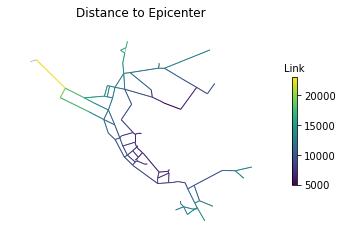

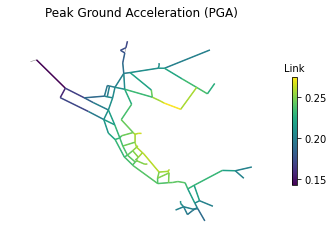

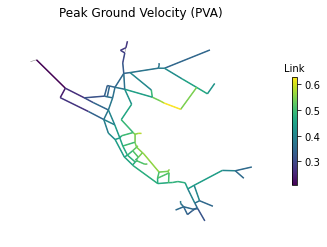

In [7]:
# Plot Distance to Epicenter
wntr.graphics.plot_network(wn, link_attribute=R, node_size=0, link_cmap = cmap, title='Distance to Epicenter')

# Plot PGA
wntr.graphics.plot_network(wn, link_attribute=pga, node_size=0, link_cmap = cmap, link_width=1.5, title='Peak Ground Acceleration (PGA)')

# Plot PGV
wntr.graphics.plot_network(wn, link_attribute=pgv, node_size=0, link_cmap = cmap, link_width=1.5, title='Peak Ground Velocity (PVA)')

#### 2e Plot repair rate (# of repairs needed per m) and repair rate * pipe length

<AxesSubplot:title={'center':'Repair Rate*Pipe Length'}>

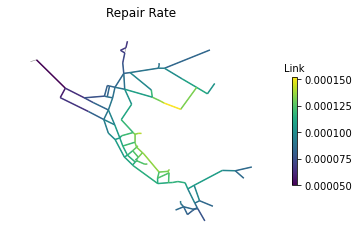

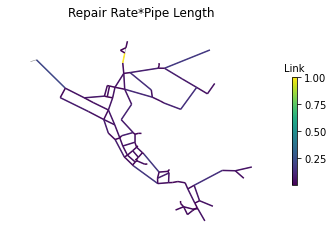

In [8]:
# Plot RR
wntr.graphics.plot_network(wn, link_attribute=RR, node_size=0, link_cmap = cmap, link_width=1.5, title='Repair Rate')

# Plot RR*Pipe Length
wntr.graphics.plot_network(wn, link_attribute=(RR*L), node_size=0, link_cmap = cmap, link_width=1.5, title='Repair Rate*Pipe Length')

#### 2f Plot probability of leaks and damage state

<AxesSubplot:title={'center':'Probability of a Major Leak'}>

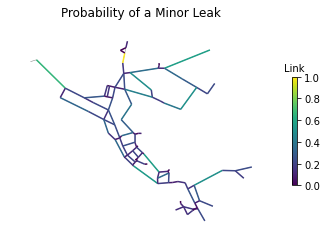

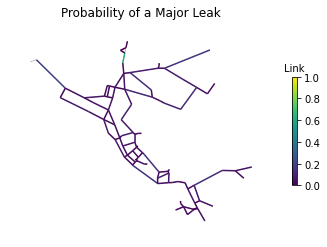

In [9]:
# Plot Probability of Minor Leak
wntr.graphics.plot_network(wn, link_attribute=pipe_Pr['Minor Leak'], node_size=0, link_cmap = cmap, link_range=[0,1], link_width=1.5, title='Probability of a Minor Leak')

# Plot Probability of Major Leak
wntr.graphics.plot_network(wn, link_attribute=pipe_Pr['Major Leak'], node_size=0, link_cmap = cmap, link_range=[0,1], link_width=1.5, title='Probability of a Major Leak')

### 3 Simulate hydraulics

#### 3a Simulate hydraulics without repair

In [10]:
# Set network parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure 

# The simulation uses pressure driven hydraulics and leak models to account for loss.
for pipe_name, damage_state in pipe_damage_state.items():
    pipe_diameter = wn.get_link(pipe_name).diameter
    if damage_state is not None:
        if damage_state == 'Major Leak':
            leak_diameter = 0.25*pipe_diameter 
            leak_area = np.pi/4.0*leak_diameter**2
        elif damage_state == 'Minor Leak':
            leak_diameter = 0.1*pipe_diameter 
            leak_area = np.pi/4.0*leak_diameter**2
        else:
            leak_area = 0

        # Add pipe leak to network
        wn = wntr.morph.split_pipe(wn,pipe_name, pipe_name+'A', 'Leak'+pipe_name)
        n = wn.get_node('Leak'+pipe_name)
        n.add_leak(wn, area=leak_area, start_time=leak_start_time)
    
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

#### 3b Identify highest leaks for repair¶

Text(0.5, 0, 'Time (hr)')

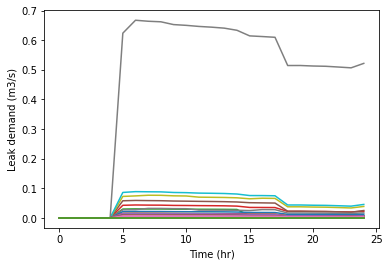

In [11]:
# Rank leaked demand
leaked_demand = results.node['leak_demand']
leaked_sum = leaked_demand.sum()
leaked_sum.sort_values(ascending=False, inplace=True)

# Plot leak demand
leaked_demand.index = leaked_demand.index/3600
ax=leaked_demand.plot(legend=False)
ax.set_ylabel('Leak demand (m3/s)')
ax.set_xlabel('Time (hr)')

In [12]:
# Select top pipes to fix
number_of_pipes_to_repair = 4
pipes_to_fix = leaked_sum[0:number_of_pipes_to_repair]
print(pipes_to_fix)

Leak329    11.914779
Leak171     1.376890
Leak159     1.177374
Leak131     0.873048
dtype: float64


#### 3c Simulate hydraulics with repair
When using the same water network model to run multiple simulations (with WNTRSimulator), initial conditions need to be reset between simulations. Initial conditions include simulation time, tank head, reservoir head, pipe status, pump status, and valve status.

In [13]:
# Reset to initial conditions
wn.reset_initial_values()

# Identify largest leaks
leaked_demand = results.node['leak_demand']
leaked_sum = leaked_demand.sum()
leaked_sum.sort_values(ascending=False, inplace=True)

number_of_pipes_to_repair = 4
leaks_to_fix = leaked_sum[0:number_of_pipes_to_repair]

# Model a partial fixed leak
for leak_name in leaks_to_fix.index:
    node = wn.get_node(leak_name)
    leak_area = node.leak_area
    node.remove_leak(wn)
    node.add_leak(wn, area=leak_area, start_time=leak_start_time, end_time=leak_repair_time)

# Simulate partial repairs
results_wrepair = sim.run_sim()

### 4 Visualize results

#### 4a Plot network pressure

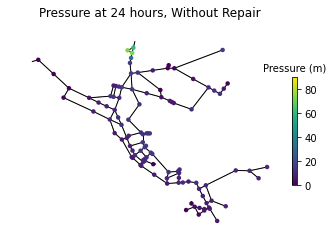

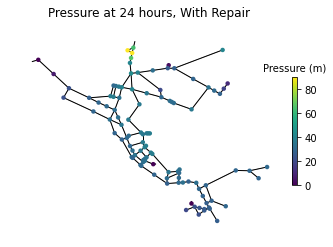

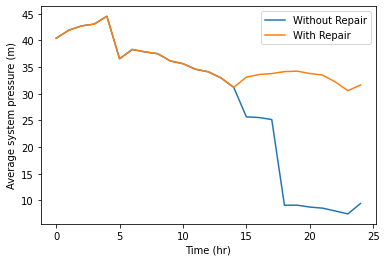

In [14]:
pressure = results.node['pressure']
pressure_wrepair = results_wrepair.node['pressure']
pressure.index = pressure.index/3600
pressure_wrepair.index = pressure_wrepair.index/3600

# Plot pressure 24hr into simulation without repair
pressure_at_24hr = pressure.loc[24,wn.junction_name_list]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_24hr, node_size=20, 
                           node_range=[0,90], node_cmap = cmap, node_colorbar_label='Pressure (m)', 
                           title='Pressure at 24 hours, Without Repair')

# Plot pressure 24hr into simulation with partial repair
pressure_at_24hr_wrepair = pressure_wrepair.loc[24,wn.junction_name_list]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_24hr_wrepair, node_size=20, 
                           node_range=[0,90], node_cmap = cmap, node_colorbar_label='Pressure (m)', 
                           title='Pressure at 24 hours, With Repair')
 
# Plot average system pressure with and without partial repairs
plt.figure()
ax = plt.gca()
pressure.loc[:,wn.junction_name_list].mean(axis=1).plot(label='Without Repair', ax=ax)
pressure_wrepair.loc[:,wn.junction_name_list].mean(axis=1).plot(label='With Repair', ax=ax)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Average system pressure (m)')
ax.legend()

#### 4b Plot water service availability

Text(0.5, 1.0, 'With Repair')

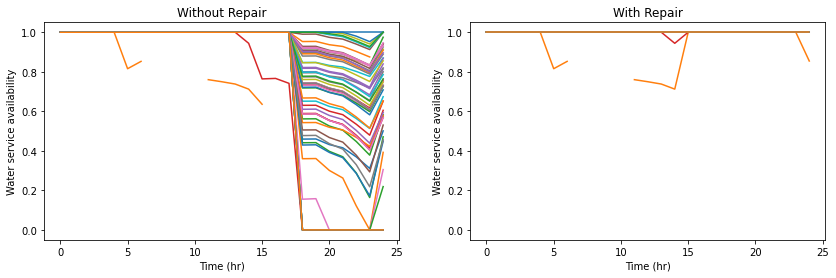

In [15]:
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]
demand_wrepair = results_wrepair.node['demand'].loc[:,wn.junction_name_list]
expected_demand.index = expected_demand.index/3600
demand.index = demand.index/3600
demand_wrepair.index = demand_wrepair.index/3600

# Calculate water service availability (WSA)
wsa = wntr.metrics.water_service_availability(expected_demand, demand)
wsa_wrepair = wntr.metrics.water_service_availability(expected_demand, demand_wrepair)

# Plot WSA
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
wsa.plot(ax=ax, legend=False)
ax.set_ylim(ymin=-0.05, ymax=1.05)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Water service availability')
ax.set_title('Without Repair')
ax = axarr[1]
wsa_wrepair.plot(ax=ax, legend=False)
ax.set_ylim(ymin=-0.05, ymax=1.05)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Water service availability')
ax.set_title('With Repair')

#### 4c Plot population impacted

Text(0.5, 1.0, 'With Repair')

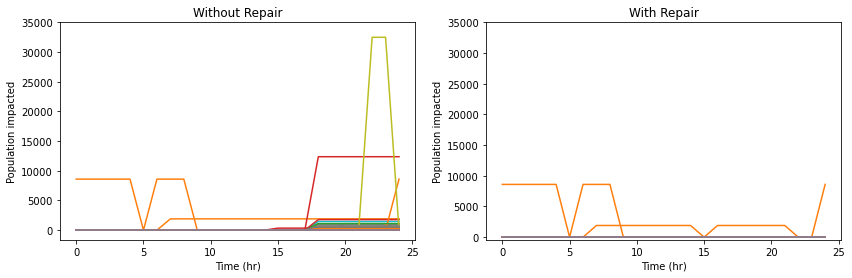

In [16]:
# Note that water service availability of NaN is replaced with 0 for the population impacted calculation
population = wntr.metrics.population(wn)
people_impacted = wntr.metrics.population_impacted(population, wsa.fillna(0), np.less, 0.8)
people_impacted_wrepair = wntr.metrics.population_impacted(population, wsa_wrepair.fillna(0), np.less, 0.8)

# Plot population impacted
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
people_impacted.plot(ax=ax, legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Population impacted')
ax.set_title('Without Repair')
ax = axarr[1]
people_impacted_wrepair.plot(ax=ax, legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Population impacted')
ax.set_title('With Repair')

#### Data Testing
The following code is included for data testing and is not required for the earthquake analysis.

In [17]:
# Test simulation results
# Import expected results
people_test = pd.read_csv('../../wntr/tests/data_for_testing/earthquake_demo_people_test_data.csv', index_col=0)
people_wrepair_test = pd.read_csv('../../wntr/tests/data_for_testing/earthquake_demo_people_wrepair_test_data.csv', index_col=0)

# Check if simulation results match expected results
assert (people_test == people_impacted).all(axis=None) == True, "impacted people results differ"
assert (people_wrepair_test == people_impacted_wrepair).all(axis=None)  == True, "impacted people wrepair results differ"